# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api
from dowhy.graph import build_graph_from_str

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
nx_graph = build_graph_from_str(data["dot_graph"])

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-0.211814,True,4.641561
1,-1.439842,False,-2.103589
2,-3.018313,False,-6.280786
3,0.225537,True,5.618419
4,0.243565,True,5.098868
...,...,...,...
995,-0.138899,False,-0.589711
996,-0.006669,True,5.867192
997,-0.988542,True,0.152702
998,-0.285568,False,-0.397086


<Axes: xlabel='v0'>

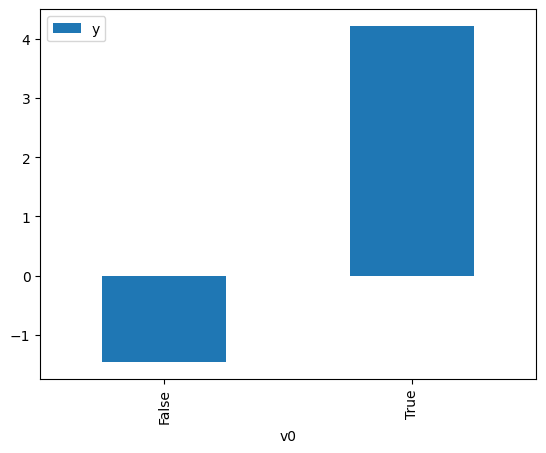

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
             variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
             outcome=outcome,
             common_causes=[common_cause],
            ).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

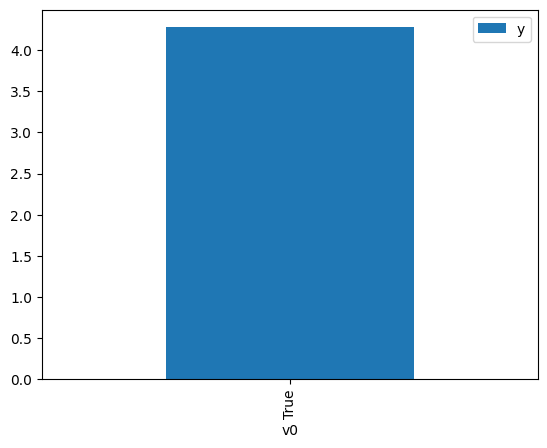

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause]
              ).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,0.125806,False,-0.295283,0.421039,2.375075
1,-1.599754,False,-4.119911,0.970327,1.030581
2,-0.590331,False,-1.678813,0.779199,1.283369
3,0.784148,False,1.636465,0.145474,6.874070
4,-0.649935,False,-1.313372,0.800986,1.248462
...,...,...,...,...,...
995,-1.906779,False,-4.188216,0.984701,1.015536
996,-1.411969,False,-2.899452,0.955774,1.046272
997,-0.478145,False,-1.886063,0.733718,1.362921
998,0.566906,False,1.063506,0.215616,4.637874


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,0.367279,True,7.015629,0.700798,1.426944
1,-0.444841,True,4.843944,0.280877,3.560272
2,0.287728,True,3.633557,0.662766,1.508829
3,0.937506,True,7.018691,0.891755,1.121384
4,0.210048,True,5.827063,0.623472,1.603920
...,...,...,...,...,...
995,-0.814377,True,1.846579,0.147397,6.784386
996,-0.893988,True,4.052781,0.126667,7.894689
997,0.081312,True,4.551162,0.554871,1.802220
998,-0.843100,True,3.743358,0.139612,7.162690


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.945
Model:                            OLS   Adj. R-squared (uncentered):              0.945
Method:                 Least Squares   F-statistic:                              8555.
Date:                Mon, 03 Nov 2025   Prob (F-statistic):                        0.00
Time:                        01:24:04   Log-Likelihood:                         -1413.6
No. Observations:                1000   AIC:                                      2831.
Df Residuals:                     998   BIC:                                      2841.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.2208      0.029     77.503      0.000       2.165       2.277
x2             4.8730      0.054     90.610      0.000       4.767       4.979
==============================================================================
Omnibus:                        1.487   Durbin-Watson:                   2.024
Prob(Omnibus):                  0.475   Jarque-Bera (JB):                1.561
Skew:                          -0.086   Prob(JB):                        0.458
Kurtosis:                       2.910   Cond. No.                         1.93
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""